# Classifying Fast-Spiking and Regular-Spiking Neurons and Visualizing Their Differences

In this notebook, we will classify **fast-spiking (FS)** neurons from **regular-spiking (RS)** neurons in visual cortical areas of the mouse brian. We will also visualize the differences between these two types of cells by comparing their peak waveforms and optotagged unit responses. This notebook utilizes open source data from the Allen Institute, but is designed to be customizable with alternative datasets.

## Environment Setup
**⚠️Note: If running on a new environment, run this cell once and then restart the kernel⚠️**

In [1]:
try:
    from dandi_utils import dandi_download_open
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dandi_utils import dandi_stream_open
from hdmf.common import DynamicTable
from pynwb import NWBHDF5IO
from pynwb.misc import Units

%matplotlib inline

## Streaming Ecephys Files

In [3]:
dandiset_id = "000022"
dandi_filepath = "sub-774672354/sub-774672354_ses-794812542.nwb"
dandi_api_key = None

In [4]:
# This can sometimes take a while depending on the size of the file
io = dandi_stream_open(dandiset_id, dandi_filepath, dandi_api_key=dandi_api_key)
nwb = io.read()

A newer version (0.56.2) of dandi/dandi-cli is available. You are using 0.55.1
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


## Accessing Data Tables
Here, we want to access data from the `Units` table of the NWB file. This table contains information about each unit from a given experiment. A unit typically refers to an individual neuron that is recorded during an extracellular electrophysiology experiment. We will also be accessing data from the `Electrodes` table of the NWB file. This table contains information about each electrode (neuropixel probe) that was used during this experiment. This is a useful place to get information about specific channels, or recording sites, that are positioned along the probe. While we will not use every column of data from both of these tables, the relevant data we extract will be explained below. 

In [5]:
units = nwb.units
units[:10]

,PT_ratio,spread,presence_ratio,recovery_slope,silhouette_score,waveform_halfwidth,cluster_id,firing_rate,amplitude_cutoff,waveform_duration,...,max_drift,cumulative_drift,local_index,velocity_below,amplitude,nn_hit_rate,isi_violations,spike_times,spike_amplitudes,waveform_mean
id,,,,,,,,,,,,,,,,,,,,,
951082751,0.419765,40.0,0.99,-0.122291,NaN,0.137353,0,7.104418,0.237403,0.206030,...,14.23,330.92,0,NaN,71.376630,0.990667,0.308011,"[4.404383589226281, 8.67118909163238, 11.03942...","[0.00010935638773041407, 0.0001053127062613349...","[[0.0, -2.834130000000002, -7.155524999999987,..."
951083991,0.535828,60.0,0.99,-0.074917,0.047790,0.109883,435,0.278519,0.130559,0.206030,...,32.94,669.23,417,0.000000,91.741455,0.453333,0.000000,"[8.196121812326329, 21.342438765612467, 23.426...","[8.26202146584441e-05, 7.495588582432538e-05, ...","[[0.0, -4.334850000000012, -0.9492600000000104..."
951082759,0.853006,50.0,0.99,-0.130682,0.221266,0.082412,3,8.925235,0.001414,0.151089,...,41.73,376.08,3,0.000000,107.288220,0.999333,0.008631,"[4.6698505982350795, 4.698917302385716, 4.7766...","[0.00013007537754279887, 0.0001180359600428186...","[[0.0, -1.106819999999991, -4.045664999999994,..."
951082767,0.348855,40.0,0.99,-0.120575,0.179655,0.068677,6,15.335853,0.053171,0.109883,...,23.85,367.74,6,0.000000,107.460210,0.998667,0.126358,"[4.6178505311766, 5.357818152094017, 5.5837184...","[8.749199442943392e-05, 8.611238834643928e-05,...","[[0.0, 1.6528199999999984, -1.7840550000000244..."
951082786,0.579262,60.0,0.99,-0.169156,0.160511,0.164824,13,1.111425,0.002400,0.274707,...,25.71,134.04,13,-0.206030,164.961225,1.000000,0.000000,"[5.93865223446196, 9.150423042978373, 17.33643...","[0.0001752243457523341, 0.00017500487733309024...","[[0.0, -3.826485000000007, -1.3634400000000007..."
951082795,0.303918,60.0,0.99,-0.053188,0.179032,0.137353,16,11.282504,0.002560,0.315913,...,17.86,101.38,16,-0.961474,84.012630,1.000000,0.009002,"[3.84931620675334, 3.861782889496847, 3.895916...","[8.129339295037826e-05, 9.441664431033754e-05,...","[[0.0, 1.0198500000000168, 2.013375000000001, ..."
951082801,0.553492,80.0,0.99,-0.047044,0.241507,0.329648,18,0.282289,0.161206,0.384590,...,20.87,272.07,18,-0.392438,65.208390,0.940171,0.479336,"[14.247296282493597, 36.373158148994705, 37.61...","[0.00010133442324299622, 8.54276743967337e-05,...","[[0.0, -0.41125499999998905, -2.76431999999999..."
951082810,0.614285,50.0,0.99,-0.074530,0.082241,0.123618,21,5.301027,0.468892,0.247236,...,19.15,180.21,21,-0.686767,68.146260,0.958667,0.086994,"[3.8538828793091167, 4.094716523217777, 5.0348...","[0.00011609751977622408, 0.0001022201410941623...","[[0.0, 0.8874450000000262, 0.13923000000000307..."
951083999,0.812881,50.0,0.99,-0.089071,0.045504,0.192295,437,4.835504,0.035226,0.288442,...,19.72,273.67,419,-0.686767,85.016100,0.852000,0.148657,"[3.726249381381607, 3.982783045536769, 4.14044...","[0.00016281725046406152, 0.0001520994002522755...","[[0.0, 2.6876850000000037, 1.1136450000000053,..."


In [6]:
# convert the electrodes table into a pandas df for easier analysis
electrodes = nwb.electrodes
electrodes_df = electrodes.to_dataframe()

# Reset the index to include it as a regular column
electrodes_df.reset_index(inplace=True)

electrodes_df[:10]

,id,x,y,z,imp,location,filtering,group,group_name,probe_vertical_position,probe_horizontal_position,probe_id,local_index,valid_data
0,849877020,7805.0,353.0,353.0,NaN,VISam,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,probeA abc.EcephysElectrodeGroup at 0x23467947...,probeA,2740,43,810758777,272,True
1,849877026,7800.0,328.0,328.0,NaN,,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,probeA abc.EcephysElectrodeGroup at 0x23467947...,probeA,2760,27,810758777,275,True
2,849877028,7798.0,320.0,320.0,NaN,,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,probeA abc.EcephysElectrodeGroup at 0x23467947...,probeA,2780,43,810758777,276,True
3,849877030,7796.0,312.0,312.0,NaN,,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,probeA abc.EcephysElectrodeGroup at 0x23467947...,probeA,2780,11,810758777,277,True
4,849877034,7793.0,297.0,297.0,NaN,,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,probeA abc.EcephysElectrodeGroup at 0x23467947...,probeA,2800,27,810758777,279,True
5,849877038,7789.0,282.0,282.0,NaN,,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,probeA abc.EcephysElectrodeGroup at 0x23467947...,probeA,2820,11,810758777,281,True
6,849877042,7786.0,267.0,267.0,NaN,,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,probeA abc.EcephysElectrodeGroup at 0x23467947...,probeA,2840,27,810758777,283,True
7,849877046,7783.0,253.0,253.0,NaN,,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,probeA abc.EcephysElectrodeGroup at 0x23467947...,probeA,2860,11,810758777,285,True
8,849877048,7782.0,246.0,246.0,NaN,,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,probeA abc.EcephysElectrodeGroup at 0x23467947...,probeA,2880,59,810758777,286,True
9,849877052,7779.0,232.0,232.0,NaN,,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,probeA abc.EcephysElectrodeGroup at 0x23467947...,probeA,2900,43,810758777,288,True


## Extracting and Aligning Particular Data From the Tables
Now we want to extract and align particular data from the `Units` and `Electrodes` tables from above. There are several criteria that need to be met in order for us to select only select neurons that will be valuable to our analysis: 
1) **Location**: The tables above contain information from every area of the brain that the probes were inserted into. However, we only want to analyze data that was collected from areas on the probe that were inserted into the visual cortical areas of the mouse brain. For this reason, we create a dictionary called `channel_to_probes_dict` to map each channel of each probe to its position within the brain so we can exclude units that are not from these desired areas. Since the channel location information is stored in the `Electrodes` table, we wrote a function called `get_unit_location` where we can input a `peak_channel_id` from the stimulus table and receive the location of the channel. This function allows us to align data from the `Electrodes` table with data from the `Units` table. We use the `cortex` list to identify which units we want to select for particular coritcal locations in the example below, and exclude any units that are not from these particular locations in the list.
2) **Electrode Validity**: The last column of the `Electrodes` table is labeled `valid_data` and tells us if data from a specific channel was valid or not. We only want to include data from channels that are 'True' (valid) for this column. We write a function called `is_electrode_valid` that will create a list of the `id` of each channel that provides valid data, so we can exclude any channel from our analysis that does not meet this criteria.
3) **Unit Quality**: One of the columns in the `Units` table called `quality` contains information about the quality of the data of each unit. We only want to include units in our analysis that have 'good' quality and are not 'noise'. To exclude the noisy units, we create a function that will return 'True' only when the unit's quality is 'good'. 

In [7]:
# create a dictionary that maps the id of a channel to its location 
channel_to_probes_dict = {}

for i in range(len(electrodes_df)):
    channel_id = electrodes_df['id'][i]
    location = electrodes_df['location'][i]
    channel_to_probes_dict[channel_id] = location

# function aligns location information from electrodes table with channel id from the units table
def get_unit_location(peak_id):
    return channel_to_probes_dict[peak_id]

In [8]:
# returns a list of channels ids that are valid within electrodes table
valid_electrode_ids = []

for i, valid in enumerate(electrodes_df['valid_data']): 
    if valid == True:
        valid_electrode_ids.append(electrodes_df['id'][i])

valid_electrode_id = set(valid_electrode_ids)

Now that we have defined some of the criteria for selecting data, we can combine what we have with some additional filtering criteria into one unified function called `select_unit` that will be used in a for loop below. When data from a specific unit is passed into this function, the function will return 'True' if that unit meets all the defined criteria. This will help us exclude units that do not meet the criteria in the loop below. You can modify this function to fit whatever criteria is most reasonable for your dataset. 

In [9]:
cortex = ['VISrl', 'VISal', 'VISam', 'VISpm', 'VISp', 'VISI']

def select_unit(quality_value, units_channel_id, valid_electrode_ids, units_violations, units_amplitude, units_presence):
    if (quality_value == 'good' and
    get_unit_location(units_channel_id) in cortex and
    units_channel_id in valid_electrode_ids and
    units_violations < 0.5 and
    units_amplitude < 0.1 and
    units_presence > 0.95):
        return True

## Plot the Distribution of Waveform Durations
Now that we have all of our unit selection criteria defined and in one function, we need to generate a list of properties from the `Units` table to plot. For this first plot, we want to plot a distribution of `waveform_duration`s for our selected units. Ideally, this will form a bimodal distribution with one peak containing the waveform durations of fast-spiking (FS) neurons and the other containing the durations of regular-spiking (RS) neurons. Characteristically, FS neurons will have shorter spike durations than RS neurons, so they will be represented by the first peak in the distribution. In order to select the `waveform_duration`s for the desired units, we first created a for-loop that loops through the `Units` table and appends the index of a unit when that unit meets the criteria. This list, `selected_unit_indices`, can be used to index specific data from the units table that meets the criteria for all the superseding plots. Next, we create a for-loop that appends a specific unit's `waveform_duration` using the `selected_unit_indices` list. This list of durations called `selected_waveform_durations` is then plotted below. 

In [10]:
selected_unit_indices = []

# loop that creates a list of units' waveform durations if the unit meets the filtering criteria
for i in range(len(units)):
    units_channel_id = units['peak_channel_id'][i]
    quality_value = units['quality'][i]
    units_violations = units['isi_violations'][i]
    units_amplitude = units['amplitude_cutoff'][i]
    units_presence = units['presence_ratio'][i]

    if select_unit(quality_value, units_channel_id, valid_electrode_ids, units_violations, units_amplitude, units_presence) == True: 
        selected_unit_indices.append(i)

print(selected_unit_indices)

[116, 121, 123, 124, 125, 126, 127, 128, 130, 131, 132, 133, 135, 136, 137, 141, 142, 143, 145, 148, 149, 151, 152, 153, 154, 156, 158, 160, 166, 167, 172, 176, 353, 355, 356, 359, 362, 364, 366, 374, 375, 377, 380, 381, 382, 383, 385, 390, 393, 394, 395, 397, 399, 400, 401, 402, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 420, 421, 424, 426, 427, 428, 430, 431, 433, 434, 435, 437, 438, 439, 441, 442, 443, 444, 447, 448, 449, 456, 457, 458, 463, 467, 470, 471, 474, 475, 478, 479, 481, 484, 489, 490, 491, 617, 620, 623, 627, 631, 632, 634, 637, 638, 639, 640, 645, 646, 647, 648, 653, 655, 656, 657, 659, 661, 663, 665, 667, 668, 672, 674, 675, 677, 682, 683, 684, 685, 687, 690, 692, 699, 701, 702, 719, 721, 723, 791, 793, 797, 799, 800, 801, 802, 803, 804, 810, 811, 812, 813, 815, 818, 819, 820, 822, 824, 825, 834, 835, 837, 910, 913, 916, 918, 919, 920, 924, 925, 926, 927, 936, 941, 943, 944, 947, 948, 949, 950, 951, 954, 955, 963, 965, 968, 971, 974, 975,

In [11]:
selected_waveform_duration = []

for i in range(len(units)):
    waveform_duration = units['waveform_duration'][i]
    if i in selected_unit_indices: 
        selected_waveform_duration.append(waveform_duration)
        
print('Number of durations that will be plotted: ', len(selected_waveform_duration))

Number of durations that will be plotted:  415


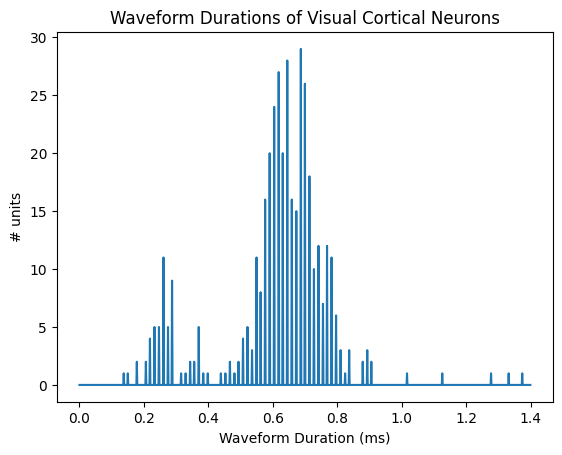

In [12]:
data = selected_waveform_duration
bins = np.linspace(0,1.4,1000)
hist, bin_edges = np.histogram(data, bins=bins)

fig, ax = plt.subplots()
ax.plot(bin_edges[:-1], hist)

plt.xlabel("Waveform Duration (ms)")
plt.ylabel("# units")
plt.title("Waveform Durations of Visual Cortical Neurons")
plt.show()

As you can see, there are two defined peaks in this bimodal distribution. We want to separate the FS neurons from the RS neurons, and to do so we must select a threshold point. This means that everything to the left of the point has shorter waveform durations and can be classified as FS neuron, and everything to the right of the point has longer waveform duration and can be classified as RS neurons. For the plot above, this threshold point falls around 0.4 ms. The threshold point usually falls in the middle between the two peaks, and, for this plot, can be identified as the space between the 2 distributions that has the fewest number of units (0) for that time in the duration.

In [13]:
# define the threshold based on the plot above
threshold = 0.4

## Plot The Waveform Profile of RS vs FS Neurons
Now that we have defined a threshold point that can classify FS neurons from RS neurons, we can plot the unit peak waveforms for each of these two categories and compare them. There are several steps that must be taken in order to do so. The waveform information in the units table is a 2D array that contains many waveforms for an individual unit. In order to select the peak waveform we want to plot from this 2D array, we need to index the array using the `local_index`. However, the local idex data is stored in the electrodes table and not the units table. First, we need to create a dictionary that maps the `id` of each channel in the `electrodes` table to its associated `local_index`. This dictionary is necessary because by mapping the index to the channel ID, we can cross reference the data between the units table and the electodes table based on a specific idenitfier. Next, we use a for-loop to append the `selected_peak_waveform` to `selected_peak_waveform_rs` if the unit's duration is above the threshold value or `selected_peak_waveform_fs` if the unit's duration is less than the threshold value. We then plot the peak waveforms on top of each other for each type of neuron independently. 

In [14]:
# create a dictionary that maps the channel id to the local index
channel_id_to_local_index = {}

for i in range(len(nwb.electrodes)):
    channel_id_to_local_index[nwb.electrodes['id'][i]] = nwb.electrodes['local_index'][i]

In [15]:
print(selected_unit_indices)

[116, 121, 123, 124, 125, 126, 127, 128, 130, 131, 132, 133, 135, 136, 137, 141, 142, 143, 145, 148, 149, 151, 152, 153, 154, 156, 158, 160, 166, 167, 172, 176, 353, 355, 356, 359, 362, 364, 366, 374, 375, 377, 380, 381, 382, 383, 385, 390, 393, 394, 395, 397, 399, 400, 401, 402, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 420, 421, 424, 426, 427, 428, 430, 431, 433, 434, 435, 437, 438, 439, 441, 442, 443, 444, 447, 448, 449, 456, 457, 458, 463, 467, 470, 471, 474, 475, 478, 479, 481, 484, 489, 490, 491, 617, 620, 623, 627, 631, 632, 634, 637, 638, 639, 640, 645, 646, 647, 648, 653, 655, 656, 657, 659, 661, 663, 665, 667, 668, 672, 674, 675, 677, 682, 683, 684, 685, 687, 690, 692, 699, 701, 702, 719, 721, 723, 791, 793, 797, 799, 800, 801, 802, 803, 804, 810, 811, 812, 813, 815, 818, 819, 820, 822, 824, 825, 834, 835, 837, 910, 913, 916, 918, 919, 920, 924, 925, 926, 927, 936, 941, 943, 944, 947, 948, 949, 950, 951, 954, 955, 963, 965, 968, 971, 974, 975,

In [16]:
selected_peak_waveform_rs = []
selected_peak_waveform_fs = []

for index in selected_unit_indices:
    waveform_duration = units['waveform_duration'][index]
    unit_mean_waveform = units['waveform_mean'][index]
    units_channel_id = units['peak_channel_id'][index]
    local_index = channel_id_to_local_index[units_channel_id]
    peak_waveform = unit_mean_waveform[local_index]

    if waveform_duration > threshold:
        selected_peak_waveform_rs.append(peak_waveform)
    else: 
        selected_peak_waveform_fs.append(peak_waveform)
        
print('number of RS waveforms to be plotted: ', len(selected_peak_waveform_rs))
print('number of FS waveforms to be plotted: ', len(selected_peak_waveform_fs))   

# convert lists into arrays and transpose for the plots
selected_peak_waveform_fs = np.array(selected_peak_waveform_fs).transpose()
selected_peak_waveform_rs = np.array(selected_peak_waveform_rs).transpose()

number of RS waveforms to be plotted:  357
number of FS waveforms to be plotted:  58


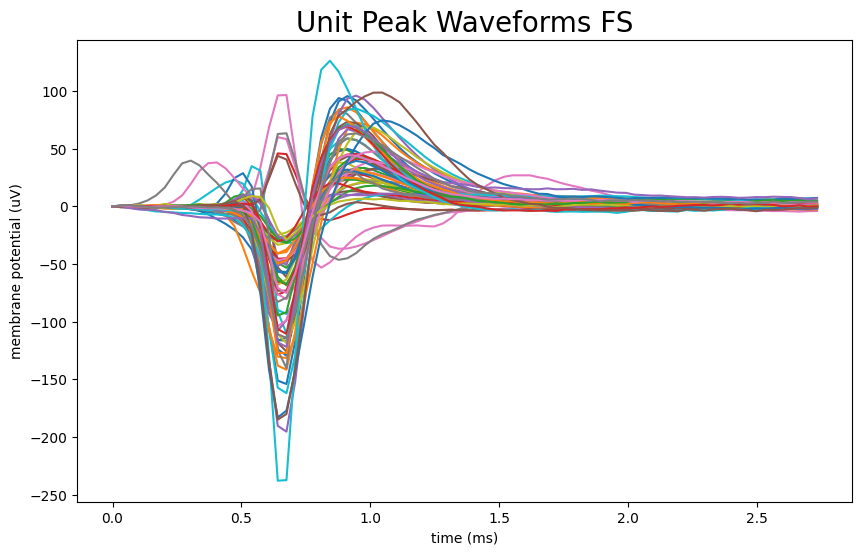

In [17]:
# these will be the same for each unit in this experiment, so we can index the first unit to define these values
Hz = list(nwb.devices.values())[0].sampling_rate
n_secs = peak_waveform.shape[0] / Hz

fig, ax = plt.subplots(figsize=(10,6))

n_secs = len(selected_peak_waveform_fs[:,0]) / Hz 
time_axis = np.linspace(0, n_secs * 1000, len(selected_peak_waveform_fs[:,0]))

ax.plot(time_axis, selected_peak_waveform_fs)

ax.set_xlabel("time (ms)")
ax.set_ylabel("membrane potential (uV)")
ax.set_title("Unit Peak Waveforms FS", fontsize=20)

plt.show()

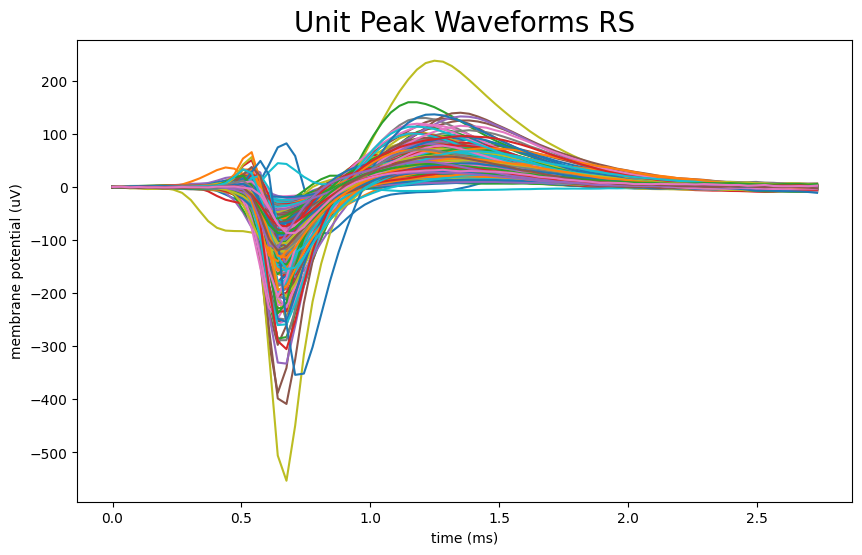

In [18]:
fig, ax = plt.subplots(figsize=(10,6))

# can do this because they are all the same length for this dataset 
n_secs = len(selected_peak_waveform_rs[:,0]) / Hz 
time_axis = np.linspace(0, n_secs * 1000, len(selected_peak_waveform_rs[:,0]))

ax.plot(time_axis, selected_peak_waveform_rs)

ax.set_xlabel("time (ms)")
ax.set_ylabel("membrane potential (uV)")
ax.set_title("Unit Peak Waveforms RS", fontsize=20)

plt.show()

### Optotagging Selected FS and RS Neurons
In some transgenic mice, particular types of neurons express a trait whereby they will fire in response to direct laser stimulation. For this dataset in particular, we want to identify if there are any optotagged neurons from the group of FS neurons that we plotted above. Typically, all optotagged neurons are inhibitory, and in the context of this experiment, FS neurons are more likely to be inhibitory than RS neurons and thus are more likely to be optotagged. Using the same filtering criteria as above, we will select FS neurons to be optotagged. For more information about optotagging, please reference our Identifying Optotagged Units Notebook. A majority of the code from this section was copied straight from the optotagging notebook. The stim_table below is an optogenetic_stimulation table that contains the intervals of time when the lasers are fired at the mouse brain. The primary data we use from this table is the start_time because this contains information about what times the stimuli are presented.

In [19]:
stim_table = nwb.processing["optotagging"]["optogenetic_stimulation"]
timestamps = nwb.processing["optotagging"]["optotagging"].timestamps
data = nwb.processing["optotagging"]["optotagging"].data

set(stim_table.duration)
stim_table[:10]

,start_time,condition,level,stop_time,stimulus_name,duration,tags,timeseries
id,,,,,,,,
0,9209.13926,half-period of a cosine wave,1.7,9210.13926,raised_cosine,1.000,[optical_stimulation],"[(0, 1, optotagging pynwb.base.TimeSeries at 0..."
1,9211.09935,a single square pulse,1.3,9211.10435,pulse,0.005,[optical_stimulation],"[(1, 1, optotagging pynwb.base.TimeSeries at 0..."
2,9212.95940,a single square pulse,1.7,9212.96940,pulse,0.010,[optical_stimulation],"[(2, 1, optotagging pynwb.base.TimeSeries at 0..."
3,9214.66951,a single square pulse,1.7,9214.67951,pulse,0.010,[optical_stimulation],"[(3, 1, optotagging pynwb.base.TimeSeries at 0..."
4,9216.74957,half-period of a cosine wave,1.7,9217.74957,raised_cosine,1.000,[optical_stimulation],"[(4, 1, optotagging pynwb.base.TimeSeries at 0..."
5,9218.79964,a single square pulse,1.3,9218.80464,pulse,0.005,[optical_stimulation],"[(5, 1, optotagging pynwb.base.TimeSeries at 0..."
6,9220.54970,half-period of a cosine wave,1.3,9221.54970,raised_cosine,1.000,[optical_stimulation],"[(6, 1, optotagging pynwb.base.TimeSeries at 0..."
7,9222.65981,a single square pulse,2.0,9222.66481,pulse,0.005,[optical_stimulation],"[(7, 1, optotagging pynwb.base.TimeSeries at 0..."
8,9224.59986,a single square pulse,1.7,9224.60486,pulse,0.005,[optical_stimulation],"[(8, 1, optotagging pynwb.base.TimeSeries at 0..."


In [20]:
# select unit spike times using similar for loop as above
unit_spike_times_rs = [] 
unit_spike_times_fs = [] 
   
for index in selected_unit_indices:
    waveform_duration = units['waveform_duration'][index]
    unit_spike_times = units['spike_times'][index]

    if waveform_duration > threshold:
        unit_spike_times_rs.append(unit_spike_times)
    else: 
        unit_spike_times_fs.append(unit_spike_times)
        
print(len(unit_spike_times_fs))
print(len(unit_spike_times_rs))   

58
357


In [21]:
# stim_select = lambda row: float(row.duration) > 0.009 and float(row.duration) < 0.012
stim_select = lambda row: True
stim_times = [float(row.start_time) for row in stim_table if stim_select(row)]

In [22]:
def get_spike_matrix(stim_times, units_spike_times, bin_edges):
    time_resolution = np.mean(np.diff(bin_edges))
    # 3D spike matrix to be populated with spike counts
    spike_matrix = np.zeros((len(units_spike_times), len(bin_edges), len(stim_times)))

    # populate 3D spike matrix for each unit for each stimulus trial by counting spikes into bins
    for unit_idx in range(len(units_spike_times)):
        spike_times = units_spike_times[unit_idx]

        for stim_idx, stim_time in enumerate(stim_times):
            # get spike times that fall within the bin's time range relative to the stim time        
            first_bin_time = stim_time + bin_edges[0]
            last_bin_time = stim_time + bin_edges[-1]
            first_spike_in_range, last_spike_in_range = np.searchsorted(spike_times, [first_bin_time, last_bin_time])
            spike_times_in_range = spike_times[first_spike_in_range:last_spike_in_range]

            # convert spike times into relative time bin indices
            bin_indices = ((spike_times_in_range - (first_bin_time)) / time_resolution).astype(int)
            
            # mark that there is a spike at these bin times for this unit on this stim trial
            for bin_idx in bin_indices:
                spike_matrix[unit_idx, bin_idx, stim_idx] += 1

    return spike_matrix

In [23]:
def get_spike_counts(stim_times, spike_times, censor_period, stim_duration, time_resolution, window_start_time, window_end_time):
    # time bins used
    n_bins = int((window_end_time - window_start_time) / time_resolution)
    bin_edges = np.linspace(window_start_time, window_end_time, n_bins, endpoint=True)

    # calculate baseline and stimulus interval indices for use later
    stim_start_time = censor_period
    stim_end_time = stim_duration - censor_period
    stim_start_idx = int((stim_start_time - (bin_edges[0])) / time_resolution)
    stim_end_idx = int((stim_end_time - (bin_edges[0])) / time_resolution)
    bl_start_idx = 0
    bl_end_idx = int((0-censor_period-bin_edges[0]) / time_resolution)

    spike_matrix = get_spike_matrix(stim_times, spike_times, bin_edges)

    # aggregate all stim trials to get total spikes by unit over time
    spike_counts = np.sum(spike_matrix, axis=2)

    return spike_counts, spike_matrix, bin_edges, bl_start_idx, bl_end_idx, stim_start_idx, stim_end_idx

### Plotting Unit Responses
In the cell below, you can change censor_period, stim_duration, time_resolution, and the window_time_start and window_time_end to adjust the plot shown by the show_counts function.

In [24]:
# period to exclude from analysis before and after the stimulus event 
censor_period = 0.001

# ending time of stimulus period
stim_duration = 0.01

# bin size for counting spikes
time_resolution = 0.0005

# start and end times (relative to the stimulus at 0 seconds) that we want to examine and align spikes to
# the baseline interval will be window_time_start to 0-censor_period
window_start_time = -0.01
window_end_time = 0.025

In [25]:
### method to show plot of spike counts of units over time

def show_counts(counts_array, bin_edges, figax=None, stim_bounds=[], title="", c_label="", vmin=None, vmax=None):
    if figax == None:
        fig, ax = plt.subplots(figsize=(6,10)) # change fig size for different plot dimensions
    else:
        fig, ax = figax

    img = ax.imshow(counts_array, 
                    extent=[np.min(bin_edges), np.max(bin_edges), 0, len(counts_array)], 
                    aspect="auto",
                    vmin=vmin,
                    vmax=vmax) # change vmax to get a better depiction of your data

    for bound in stim_bounds:
        ax.plot([bound, bound],[0, len(counts_array)], ':', color='white', linewidth=1.0)

    ax.set_xlabel("Time relative to stimulus onset (s)")
    ax.set_ylabel("Unit #")
    ax.set_title(title)

    cbar = fig.colorbar(img, shrink=0.5)
    cbar.set_label(c_label)

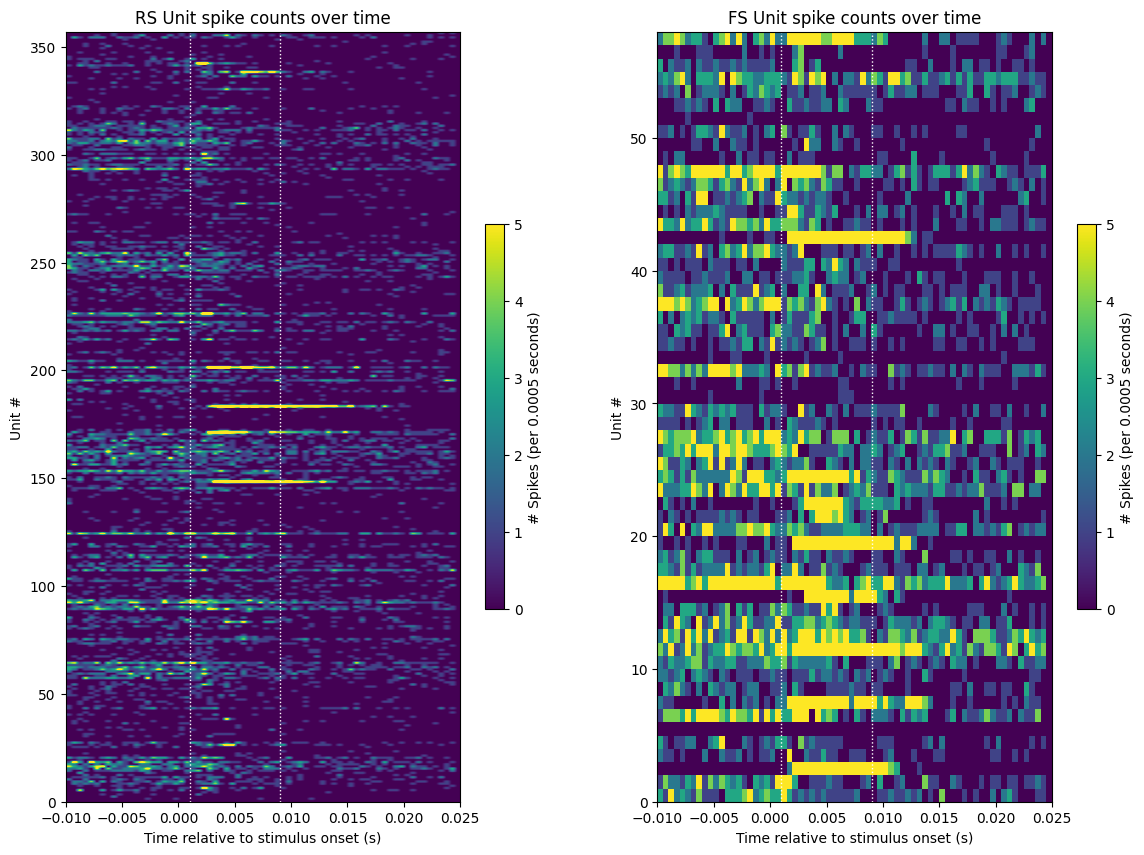

In [26]:
rs_spike_counts, _, rs_bin_edges, _, _, _, _ = get_spike_counts(stim_times, unit_spike_times_rs, censor_period, stim_duration, time_resolution, window_start_time, window_end_time)
fs_spike_counts, _, fs_bin_edges, _, _, _, _ = get_spike_counts(stim_times, unit_spike_times_fs, censor_period, stim_duration, time_resolution, window_start_time, window_end_time)

fig, axes = plt.subplots(1,2, figsize=(14,10))

show_counts(rs_spike_counts,
            rs_bin_edges,
            figax = (fig, axes[0]),
            stim_bounds=[censor_period, stim_duration-censor_period],
            title="RS Unit spike counts over time",
            c_label=f"# Spikes (per {time_resolution} seconds)",
            vmin=0,
            vmax=5)

show_counts(fs_spike_counts,
            fs_bin_edges,
            figax = (fig, axes[1]),
            stim_bounds=[censor_period, stim_duration-censor_period],
            title="FS Unit spike counts over time",
            c_label=f"# Spikes (per {time_resolution} seconds)",
            vmin=0,
            vmax=5)